In [2]:
import pandas as pd
import numpy as np

import csv, pickle, glob, bz2

from datetime import datetime

#import dill as pickle

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm
import matplotlib.collections as mcoll
import matplotlib.path as mpath
from matplotlib import rc

# # #rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
# rc('font',**{'family':'serif','serif':['Computer Modern']})
# rc('text', usetex = True)

# Local path to dropbox Paths
path_to_vatic_outputs = r'/Users/Guille/Dropbox/ProcessedDataTexas/vatic_output/Texas-7k/'

# Vatic report features
vatic_ = ['FixedCosts',       'VariableCosts',  'LoadShedding',        'OverGeneration',        'AvailableReserves',     
          'ReserveShortfall', 'RenewablesUsed', 'RenewablesAvailable', 'RenewablesCurtailment', 'Demand',             
          'Price',            'Number on/offs', 'Sum on/off ramps',    'Sum nominal ramps']

# Load shyncronized Vatic and scenarios data

* The structure in the scenarios is [days x zones x hours x scenarios]
* The structure in the Vatic reports is [days x feature x hours x scenarios]

In [3]:
# Load cnlsim scenarios organized by zones
def _loadScen(file_name):

    with open(file_name, 'rb') as f:
        scen_ = pickle.load(f)

    load_, solar_, wind_ = scen_

    load_data_, load_zones_, _              = load_
    solar_data_, solar_zones_, solar_names_ = solar_
    wind_data_, wind_zones_, wind_names_    = wind_
    load_zones_ = np.array(load_zones_)
    #print(load_data_.shape, load_zones_.shape)
    #print(solar_data_.shape, solar_zones_.shape, solar_names_.shape)
    #print(wind_data_.shape, wind_zones_.shape, wind_names_.shape)

    solar_ = []
    wind_  = []
    for zone in load_zones_:
        #print(zone)
        idx_ = solar_zones_ == zone

        if idx_.sum() == 0:
            solar_.append(np.zeros((1, 1000, 24)))
        else:
            solar_.append(np.sum(solar_data_[idx_, ...], axis = 0)[np.newaxis, ...])

        idx_ = wind_zones_ == zone
        if idx_.sum() == 0:
            wind_.append(np.zeros((1, 1000, 24)))
        else:
            wind_.append(np.sum(wind_data_[idx_, ...], axis = 0)[np.newaxis, ...])

    L_ = load_data_
    S_ = np.swapaxes(np.concatenate(solar_, axis = 0), 1, 2)
    W_ = np.swapaxes(np.concatenate(wind_, axis = 0), 1, 2)

    return L_, S_, W_, load_zones_

# Load Vatic Reports for a give file
def _loadVatic(path):
    summary_ = []
    idx_ = []
    for file_ in glob.glob(path + r'/*'):
        idx1 = file_.find('2_s')
        idx2 = file_.find('_clnSim')
        idx_.append(int(file_[idx1 + 3:idx2]))
        summary_.append(pd.read_pickle(file_).to_numpy()[..., np.newaxis])
    return np.swapaxes(np.concatenate(summary_, axis = 2)[..., np.argsort(np.array(idx_))], 0, 1)

# Load zonal scenarios and Vatic reports 
allL_  = []
allS_  = []
allW_  = []
allV_  = []
dates_ = []
for file_ in glob.glob(path_to_vatic_outputs + 'ProcessedScenTexas/*'):
    print(file_)
    dates_.append(file_[-14:-4])
    L_, S_, W_, load_zones_ = _loadScen(file_)
    V_ = _loadVatic(path_to_vatic_outputs + 'VaticReportTexas/' + file_[-14:-4])
    allL_.append(L_)
    allS_.append(S_)
    allW_.append(W_)
    allV_.append(V_)

# Organize dataset in chronological order
dates_ = np.array(dates_)
dates_ = dates_[np.argsort(dates_)]
# Load scenarios
allL_  = np.stack(allL_)[np.argsort(dates_), ...]
# Solar scenarios
allS_  = np.stack(allS_)[np.argsort(dates_), ...]
# Wind scenarios
allW_  = np.stack(allW_)[np.argsort(dates_), ...]
# Vatic report per scenarios
allV_  = np.stack(allV_)[np.argsort(dates_), ...]
print(allL_.shape, allS_.shape, allW_.shape, allV_.shape)

/Users/Guille/Dropbox/ProcessedDataTexas/vatic_output/Texas-7k/ProcessedScenTexas/2018-05-10.pkl
/Users/Guille/Dropbox/ProcessedDataTexas/vatic_output/Texas-7k/ProcessedScenTexas/2018-09-04.pkl
/Users/Guille/Dropbox/ProcessedDataTexas/vatic_output/Texas-7k/ProcessedScenTexas/2018-02-26.pkl
/Users/Guille/Dropbox/ProcessedDataTexas/vatic_output/Texas-7k/ProcessedScenTexas/2018-12-27.pkl
/Users/Guille/Dropbox/ProcessedDataTexas/vatic_output/Texas-7k/ProcessedScenTexas/2018-09-14.pkl
/Users/Guille/Dropbox/ProcessedDataTexas/vatic_output/Texas-7k/ProcessedScenTexas/2018-11-13.pkl
/Users/Guille/Dropbox/ProcessedDataTexas/vatic_output/Texas-7k/ProcessedScenTexas/2018-01-02.pkl
/Users/Guille/Dropbox/ProcessedDataTexas/vatic_output/Texas-7k/ProcessedScenTexas/2018-08-18.pkl
/Users/Guille/Dropbox/ProcessedDataTexas/vatic_output/Texas-7k/ProcessedScenTexas/2018-04-24.pkl
/Users/Guille/Dropbox/ProcessedDataTexas/vatic_output/Texas-7k/ProcessedScenTexas/2018-06-30.pkl
/Users/Guille/Dropbox/Processe

## Aggreated Scenarios 

* Find extreme scenarios: load shedding or/and renewable energy curtailment

2018-01-02
36 368 26


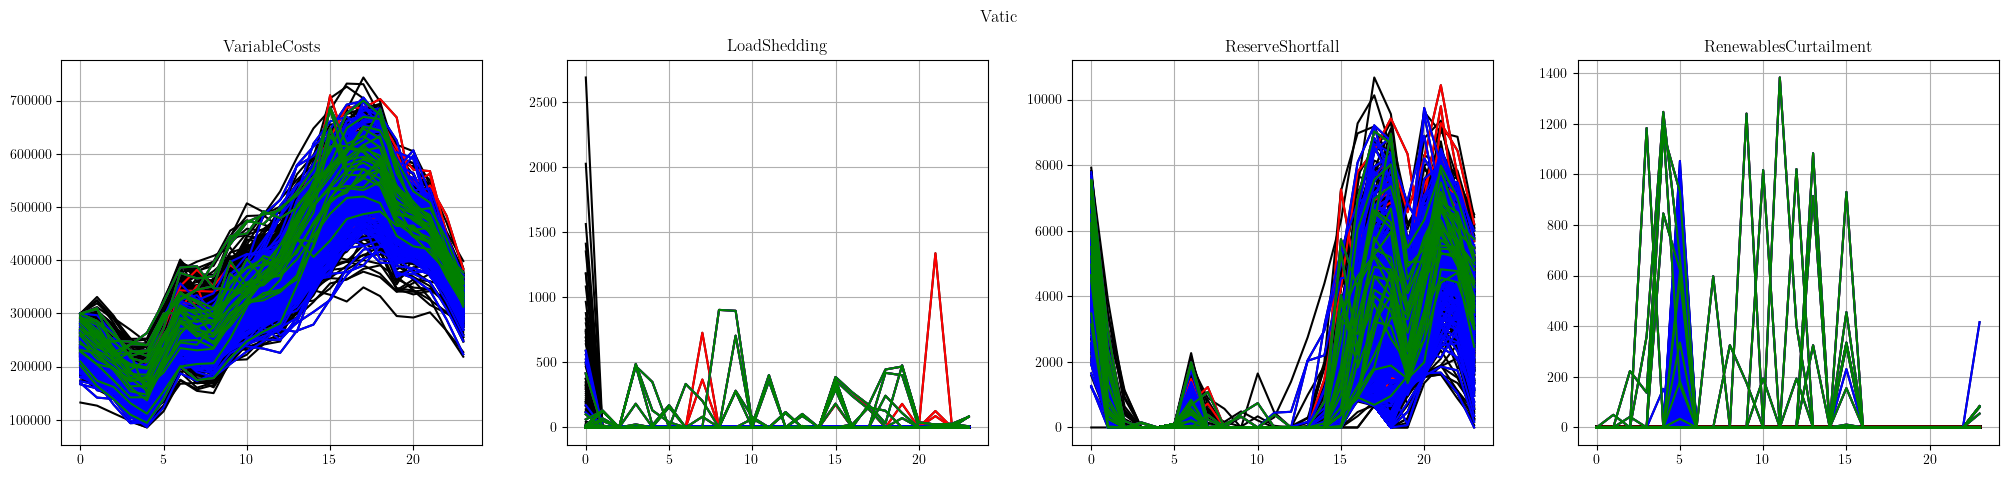

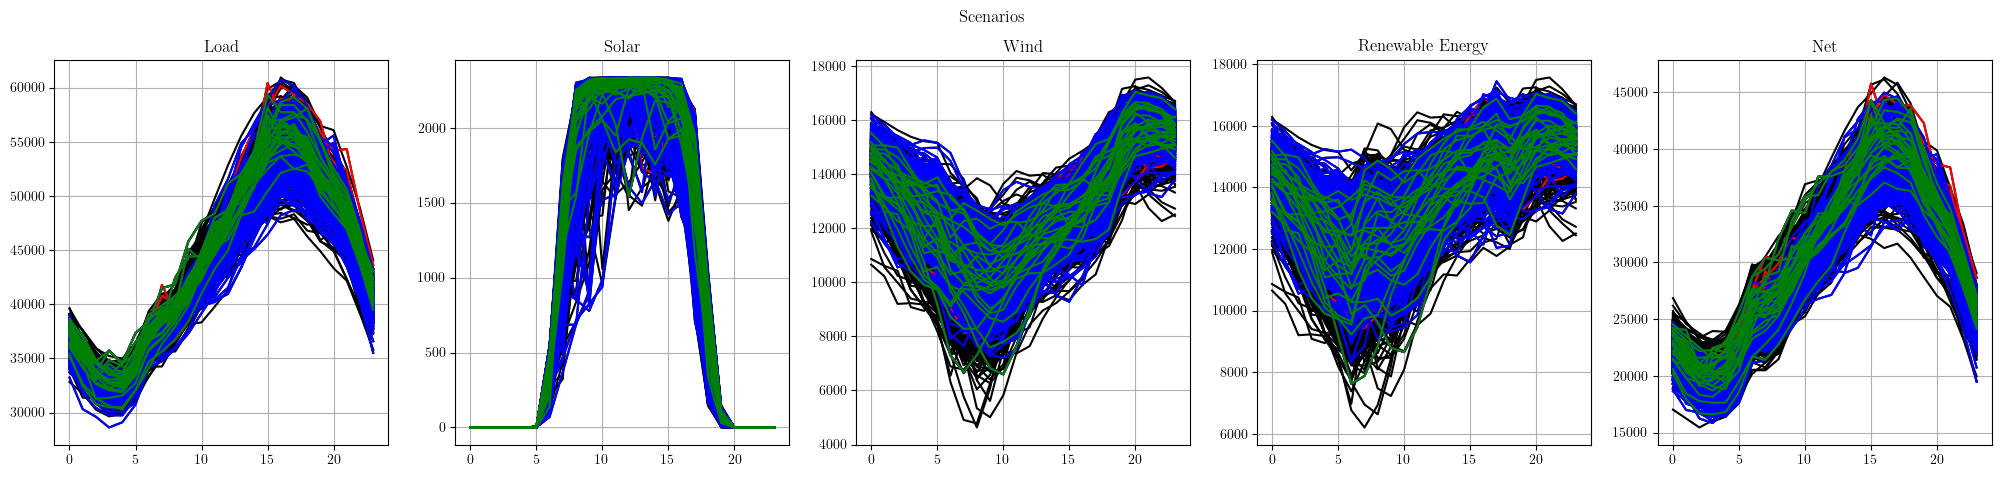

In [8]:
# Index day to plot
i_day = 0
print(dates_[i_day])

# Define scenarios indexes
idxScen_ = np.linspace(0, 999, 1000, dtype = int)
# Find scenarios with shedding events exlucing the first hour
idxShed_ = np.sum(allV_[i_day, 2, 1:, :], axis = 0) > 0.
# Find scenarios with renewable energy curtailment events exlucing the first hour
idxCurt_ = np.sum(allV_[i_day, 8, 1:, :], axis = 0) > 0.
print(idxShed_.sum(), idxCurt_.sum(), (idxCurt_ & idxShed_).sum())

plt.figure(figsize = (25, 5))
plt.suptitle('Vatic')
plt.subplot(141)
i_vatic = 1
plt.title(vatic_[i_vatic])
plt.plot(allV_[i_day, i_vatic, ...], 'k')
plt.plot(allV_[i_day, i_vatic, :, idxScen_[idxShed_]].T, 'r')
plt.plot(allV_[i_day, i_vatic, :, idxScen_[idxCurt_]].T, 'b')
plt.plot(allV_[i_day, i_vatic, :, idxScen_[idxShed_ & idxCurt_]].T, 'g')
plt.grid()

plt.subplot(142)
i_vatic = 2
plt.title(vatic_[i_vatic])
plt.plot(allV_[i_day, i_vatic, ...], 'k')
plt.plot(allV_[i_day, i_vatic, :, idxScen_[idxShed_]].T, 'r')
plt.plot(allV_[i_day, i_vatic, :, idxScen_[idxCurt_]].T, 'b')
plt.plot(allV_[i_day, i_vatic, :, idxScen_[idxShed_ & idxCurt_]].T, 'g')
plt.grid()

plt.subplot(143)
i_vatic = 5
plt.title(vatic_[i_vatic])
plt.plot(allV_[i_day, i_vatic, ...], 'k')
plt.plot(allV_[i_day, i_vatic, :, idxScen_[idxShed_]].T, 'r')
plt.plot(allV_[i_day, i_vatic, :, idxScen_[idxCurt_]].T, 'b')
plt.plot(allV_[i_day, i_vatic, :, idxScen_[idxShed_ & idxCurt_]].T, 'g')
plt.grid()

plt.subplot(144)
i_vatic = 8
plt.title(vatic_[i_vatic])
plt.plot(allV_[i_day, i_vatic, ...], 'k')
plt.plot(allV_[i_day, i_vatic, :, idxScen_[idxShed_]].T, 'r')
plt.plot(allV_[i_day, i_vatic, :, idxScen_[idxCurt_]].T, 'b')
plt.plot(allV_[i_day, i_vatic, :, idxScen_[idxShed_ & idxCurt_]].T, 'g')
plt.grid()
plt.show()

plt.figure(figsize = (25, 5))
plt.suptitle('Scenarios')
plt.subplot(151)
plt.title('Load')
plt.plot(np.sum(allL_[i_day, ...], axis = 0), 'k')
plt.plot(np.sum(allL_[i_day, ...], axis = 0)[..., idxScen_[idxShed_]], 'r')
plt.plot(np.sum(allL_[i_day, ...], axis = 0)[..., idxScen_[idxCurt_]], 'b')
plt.plot(np.sum(allL_[i_day, ...], axis = 0)[..., idxScen_[idxShed_ & idxCurt_]], 'g')
plt.grid()

plt.subplot(152)
plt.title('Solar')
plt.plot(np.sum(allS_[i_day, ...], axis = 0), 'k')
plt.plot(np.sum(allS_[i_day, ...], axis = 0)[..., idxScen_[idxShed_]], 'r')
plt.plot(np.sum(allS_[i_day, ...], axis = 0)[..., idxScen_[idxCurt_]], 'b')
plt.plot(np.sum(allS_[i_day, ...], axis = 0)[..., idxScen_[idxShed_ & idxCurt_]], 'g')
plt.grid()

plt.subplot(153)
plt.title('Wind')
plt.plot(np.sum(allW_[i_day, ...], axis = 0), 'k')
plt.plot(np.sum(allW_[i_day, ...], axis = 0)[..., idxScen_[idxShed_]], 'r')
plt.plot(np.sum(allW_[i_day, ...], axis = 0)[..., idxScen_[idxCurt_]], 'b')
plt.plot(np.sum(allW_[i_day, ...], axis = 0)[..., idxScen_[idxShed_ & idxCurt_]], 'g')
plt.grid()

plt.subplot(154)
plt.title('Renewable Energy')
plt.plot(np.sum(allS_[i_day, ...], axis = 0) 
         + np.sum(allW_[i_day, ...], axis = 0), 'k')

plt.plot(np.sum(allS_[i_day, ...], axis = 0)[..., idxScen_[idxShed_]] 
         + np.sum(allW_[i_day, ...], axis = 0)[..., idxScen_[idxShed_]], 'r')

plt.plot(np.sum(allS_[i_day, ...], axis = 0)[..., idxScen_[idxCurt_]]
         + np.sum(allW_[i_day, ...], axis = 0)[..., idxScen_[idxCurt_]], 'b')

plt.plot(np.sum(allS_[i_day, ...], axis = 0)[..., idxScen_[idxShed_ & idxCurt_]] 
         + np.sum(allW_[i_day, ...], axis = 0)[..., idxScen_[idxShed_ & idxCurt_]], 'g')
plt.grid()

plt.subplot(155)
plt.title('Net')
plt.plot(np.sum(allL_[i_day, ...], axis = 0) 
          - np.sum(allS_[i_day, ...], axis = 0) 
              - np.sum(allW_[i_day, ...], axis = 0), 'k')

plt.plot(np.sum(allL_[i_day, ...], axis = 0)[..., idxScen_[idxShed_]] 
         - np.sum(allS_[i_day, ...], axis = 0)[..., idxScen_[idxShed_]] 
             - np.sum(allW_[i_day, ...], axis = 0)[..., idxScen_[idxShed_]], 'r')

plt.plot(np.sum(allL_[i_day, ...], axis = 0)[..., idxScen_[idxCurt_]] 
         - np.sum(allS_[i_day, ...], axis = 0)[..., idxScen_[idxCurt_]]
             - np.sum(allW_[i_day, ...], axis = 0)[..., idxScen_[idxCurt_]], 'b')

plt.plot(np.sum(allL_[i_day, ...], axis = 0)[..., idxScen_[idxShed_ & idxCurt_]] 
         - np.sum(allS_[i_day, ...], axis = 0)[..., idxScen_[idxShed_ & idxCurt_]] 
             - np.sum(allW_[i_day, ...], axis = 0)[..., idxScen_[idxShed_ & idxCurt_]], 'g')
plt.grid()
plt.show()

## Zonal Scenarios 

* Find extreme scenarios: load shedding or/and renewable energy curtailment

2018-01-02
36 368 26


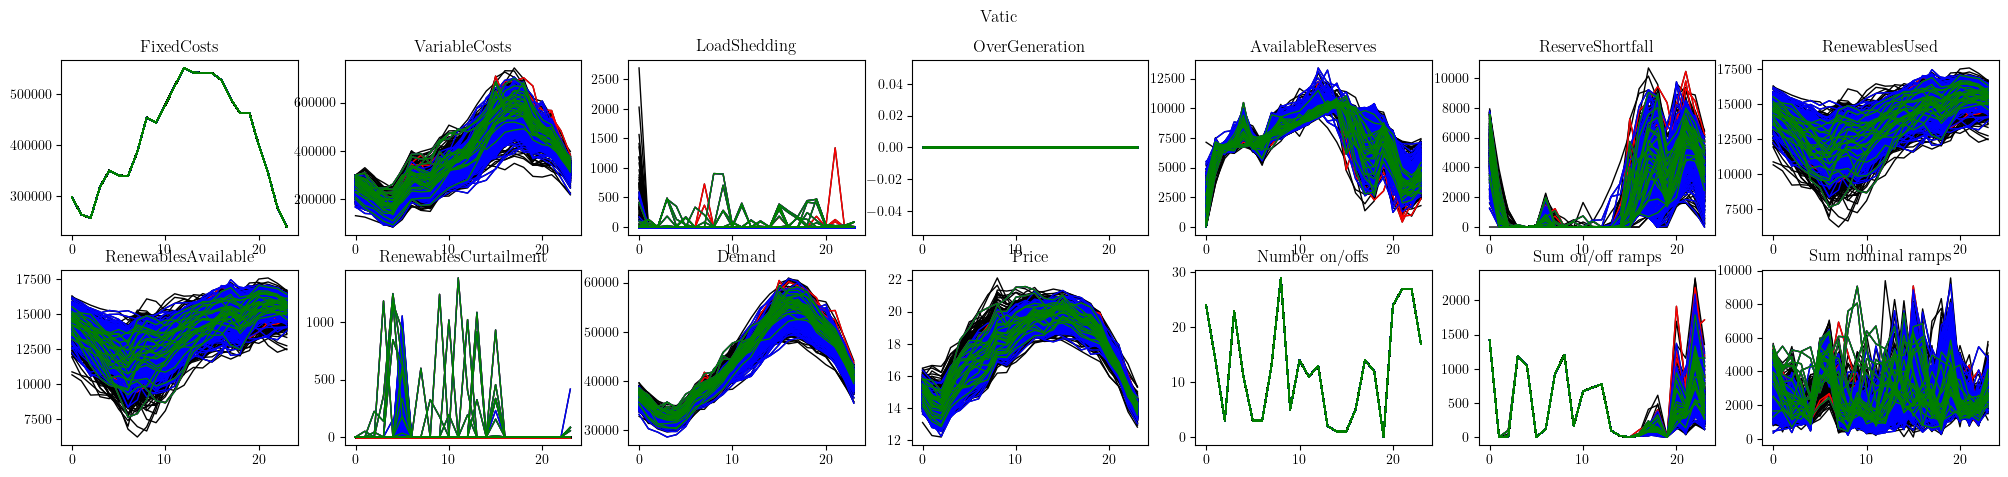

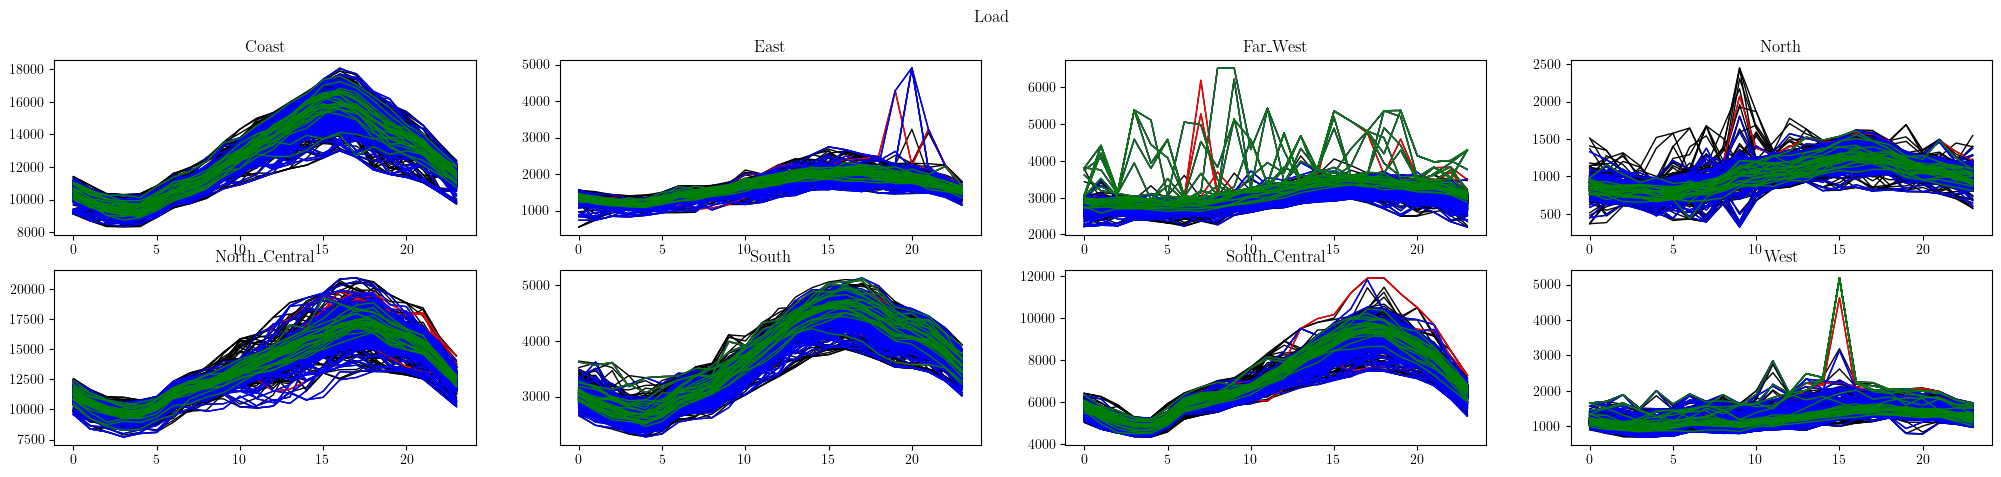

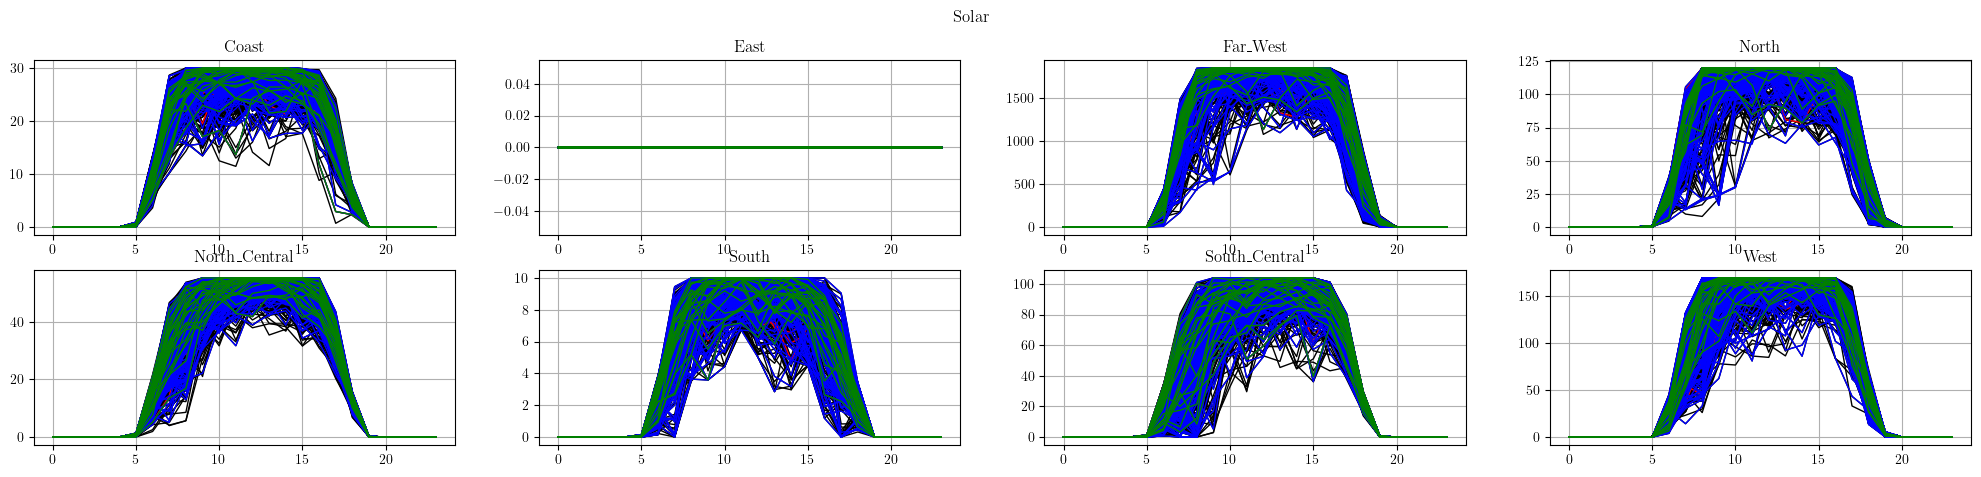

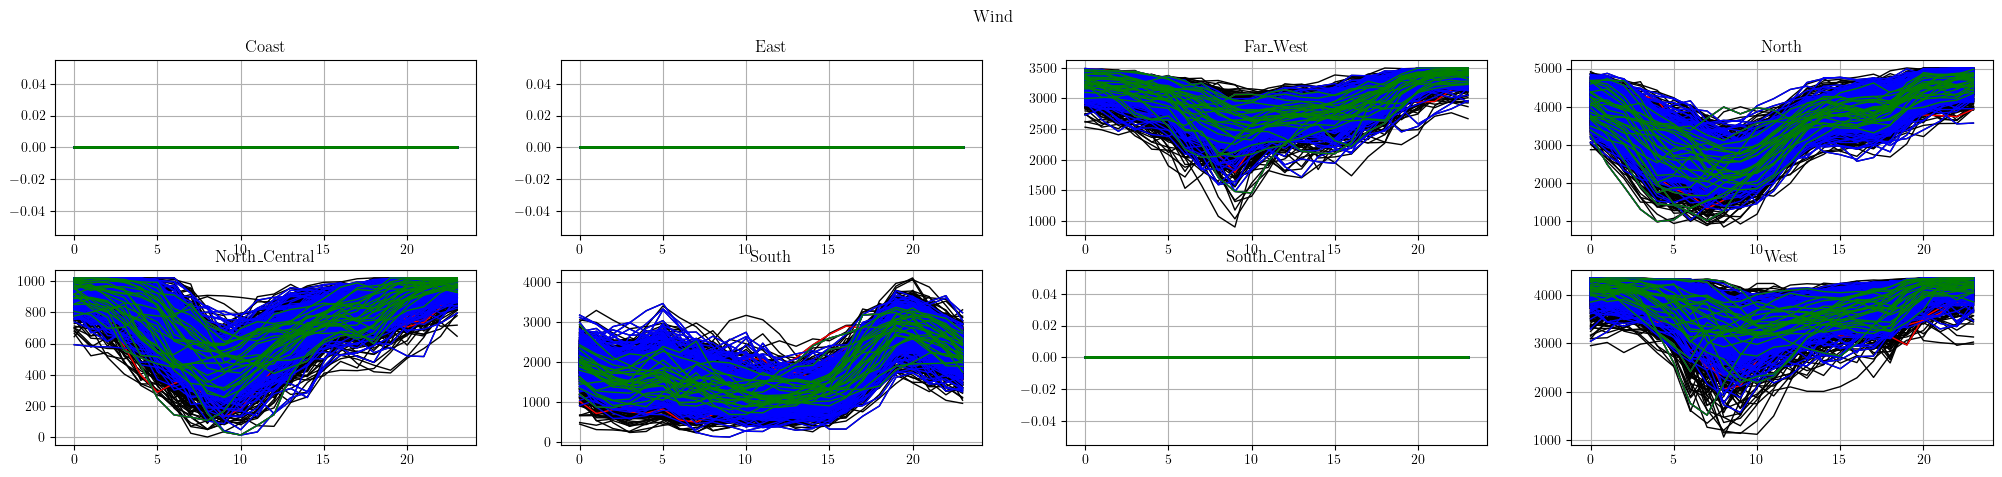

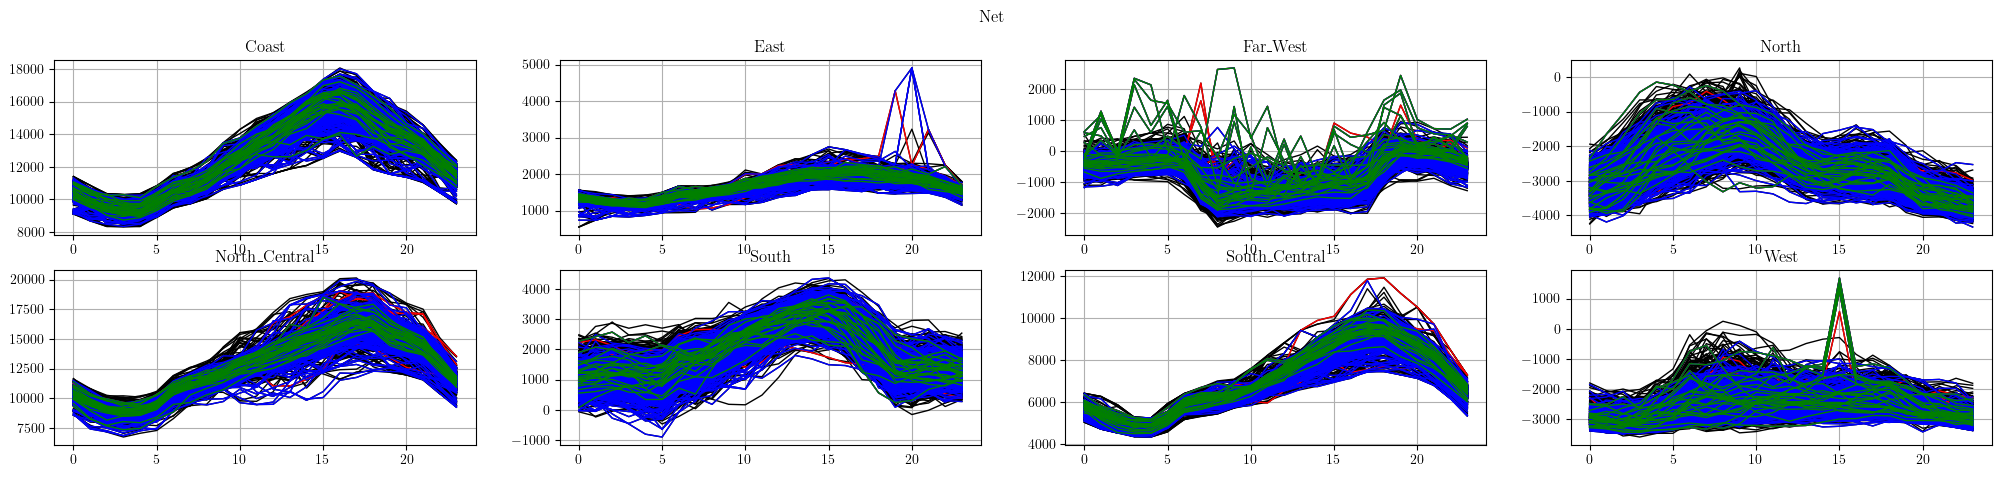

In [7]:
# Index day to plot
i_day = 0
print(dates_[i_day])

# Define scenarios indexes
idxScen_ = np.linspace(0, 999, 1000, dtype = int)
# Find scenarios with shedding events exlucing the first hour
idxShed_ = np.sum(allV_[i_day, 2, 1:, :], axis = 0) > 0.
# Find scenarios with renewable energy curtailment events exlucing the first hour
idxCurt_ = np.sum(allV_[i_day, 8, 1:, :], axis = 0) > 0.
print(idxShed_.sum(), idxCurt_.sum(), (idxCurt_ & idxShed_).sum())

plt.figure(figsize = (25, 5))
plt.suptitle('Vatic')
for j in range(14):
    plt.subplot(2, 7, j + 1)
    plt.title(vatic_[j])
    plt.plot(allV_[i_day, j, ...], 'k', linewidth = 1.)
    plt.plot(allV_[i_day, j, :, idxScen_[idxShed_]].T, 'r', linewidth = 1.)
    plt.plot(allV_[i_day, j, :, idxScen_[idxCurt_]].T, 'b', linewidth = 1.)
    plt.plot(allV_[i_day, j, :, idxScen_[idxShed_ & idxCurt_]].T, 'g', linewidth = 1.)
    plt.grid()
plt.show()

plt.figure(figsize = (25, 5))
plt.suptitle('Load Scenarios')

for j in range(8):
    plt.subplot(2, 4, j + 1)
    plt.title(load_zones_[j])
    plt.plot(allL_[i_day, j, ...], 'k', linewidth = 1.)
    plt.plot(allL_[i_day, j, :, idxScen_[idxShed_]].T, 'r', linewidth = 1.)
    plt.plot(allL_[i_day, j, :, idxScen_[idxCurt_]].T, 'b', linewidth = 1.)
    plt.plot(allL_[i_day, j, :, idxScen_[idxShed_ & idxCurt_]].T, 'g', linewidth = 1.)    
    plt.grid()
plt.show()

plt.figure(figsize = (25, 5))
plt.suptitle('Solar Scenarios')
for j in range(8):
    plt.subplot(2, 4, j + 1)
    plt.title(load_zones_[j])
    plt.plot(allS_[i_day, j, ...], 'k', linewidth = 1.)
    plt.plot(allS_[i_day, j, :, idxScen_[idxShed_]].T, 'r', linewidth = 1.)
    plt.plot(allS_[i_day, j, :, idxScen_[idxCurt_]].T, 'b', linewidth = 1.)
    plt.plot(allS_[i_day, j, :, idxScen_[idxShed_ & idxCurt_]].T, 'g', linewidth = 1.)    
    plt.grid()
plt.show()

plt.figure(figsize = (25, 5))
plt.suptitle('Wind Scenarios')
for j in range(8):
    plt.subplot(2, 4, j + 1)
    plt.title(load_zones_[j])
    plt.plot(allW_[i_day, j, ...], 'k', linewidth = 1.)
    plt.plot(allW_[i_day, j, :, idxScen_[idxShed_]].T, 'r', linewidth = 1.)
    plt.plot(allW_[i_day, j, :, idxScen_[idxCurt_]].T, 'b', linewidth = 1.)
    plt.plot(allW_[i_day, j, :, idxScen_[idxShed_ & idxCurt_]].T, 'g', linewidth = 1.)    
    plt.grid()
plt.show()

plt.figure(figsize = (25, 5))
plt.suptitle('Net Scenarios')
for j in range(8):
    plt.subplot(2, 4, j + 1)
    plt.title(load_zones_[j])
    plt.plot(allL_[i_day, j, ...] - allS_[i_day, j, ...] - allW_[i_day, j, ...], 'k', linewidth = 1.)
    plt.plot(allL_[i_day, j, :, idxScen_[idxShed_]].T - allS_[i_day, j, :, idxScen_[idxShed_]].T - allW_[i_day, j, :, idxScen_[idxShed_]].T, 'r', linewidth = 1.)
    plt.plot(allL_[i_day, j, :, idxScen_[idxCurt_]].T - allS_[i_day, j, :, idxScen_[idxCurt_]].T - allW_[i_day, j, :, idxScen_[idxCurt_]].T, 'b', linewidth = 1.)
    plt.plot(allL_[i_day, j, :, idxScen_[idxShed_ & idxCurt_]].T - allS_[i_day, j, :, idxScen_[idxShed_ & idxCurt_]].T - allW_[i_day, j, :, idxScen_[idxShed_ & idxCurt_]].T, 'g', linewidth = 1.)    
    plt.grid()
plt.show()

In [9]:
def _agg_and_zonal_select(f_, N_sel_, N_sel):
    print(N_sel_)
    idxSel_p_ = np.unique(np.concatenate([np.argsort(f_[i_zone, :])[::-1][:int(N_sel_[i_zone])] for i_zone in range(f_.shape[0])], axis = 0))
    if idxSel_p_.shape[0] > N_sel:
        idxSel_   = np.random.choice(idxSel_p_, size = N_sel, replace = False)#[:N_sel]
    else:
        idxSel_ = idxSel_p_
    print(np.sum(N_sel_), idxSel_p_.shape, idxSel_.shape)
    
    return idxSel_

# Index day to plot
i_day = 0
print(dates_[i_day])

# Define scenarios indexes
idxScen_ = np.linspace(0, 999, 1000, dtype = int)
# Find scenarios with shedding events exlucing the first hour
idxShed_ = np.sum(allV_[i_day, 2, 1:, :], axis = 0) > 0.
# Find scenarios with renewable energy curtailment events exlucing the first hour
idxCurt_ = np.sum(allV_[i_day, 8, 1:, :], axis = 0) > 0.
print(idxShed_.sum(), idxCurt_.sum(), (idxCurt_ & idxShed_).sum())


allN_ = allL_ - allS_ - allW_

aggLoad_      = np.min(np.sum(allL_[i_day, :, 1:, :], axis = 1), axis = 0)
zonalLoad_    = np.min(allL_[i_day, :, 1:, :], axis = 1)
aggZonalLoad_ = np.concatenate((aggLoad_[np.newaxis, :], zonalLoad_), axis = 0)
print(aggLoad_.shape, zonalLoad_.shape, aggZonalLoad_.shape)

#idxSel_ = _agg_and_zonal_select(aggZonalLoad_, N_sel_ = np.array([70, 0, 10, 75, 5, 65, 0, 50, 5])*2.25, N_sel = 400)
idxSel_ = _agg_and_zonal_select(aggZonalLoad_, N_sel_ = [200, 0, 0, 0, 0, 0, 0, 0, 0], N_sel = 200)

print(np.intersect1d(idxScen_[idxCurt_], idxScen_[idxSel_]).shape[0]/idxCurt_.sum())

2018-01-02
36 368
(1000,) (8, 1000) (9, 1000)
[200, 0, 0, 0, 0, 0, 0, 0, 0]
200 (200,) (200,)
0.17119565217391305


In [507]:
for i_day in range(25):

    allN_ = allL_ - allS_ - allW_

    idxShed_ = np.sum(allV_[i_day, 2, 1:, :], axis = 0) > 0.
    idxCurt_ = np.sum(allV_[i_day, 8, 1:, :], axis = 0) > 0.
    idxScen_ = np.linspace(0, 999, 1000, dtype = int)

    aggLoad_      = np.sum(np.sum(allN_[i_day, :, 1:, :], axis = 1), axis = 0)
    zonalLoad_    = np.sum(allN_[i_day, :, 1:, :], axis = 1)
    aggZonalLoad_ = np.concatenate((aggLoad_[np.newaxis, :], zonalLoad_), axis = 0)

    #idxSel_ = _agg_and_zonal_select(aggZonalLoad_, N_sel_ = [200, 0, 0, 0, 0, 0, 0, 0, 0], N_sel = 200)
    #idxSel_ = _agg_and_zonal_select(aggZonalLoad_, N_sel_ = [55, 0, 25, 50, 20, 40, 40, 30, 55], N_sel = 200)
    idxSel_ = _agg_and_zonal_select(aggZonalLoad_, N_sel_ = [70, 0, 10, 75, 5, 65, 0, 50, 5], N_sel = 200)

    print(dates_[i_day], idxShed_.sum(), idxCurt_.sum(), np.intersect1d(idxScen_[idxShed_], idxScen_[idxSel_]).shape[0]/idxShed_.sum())

2018-05-10 36 368 0.6666666666666666
2018-09-04 7 0 0.7142857142857143
2018-02-26 21 304 0.8571428571428571
2018-12-27 171 119 0.52046783625731
2018-09-14 5 2 0.8
2018-11-13 178 100 0.5393258426966292
2018-01-02 678 501 0.2359882005899705
2018-08-18 23 33 0.7391304347826086
2018-04-24 127 191 0.5275590551181102
2018-06-30 49 23 0.4897959183673469
2018-03-14 66 129 0.6363636363636364
2018-04-09 57 33 0.5614035087719298
2018-08-08 195 336 0.5487179487179488
2018-11-02 34 715 0.4411764705882353
2018-01-20 41 516 0.8048780487804879
2018-04-01 11 79 0.8181818181818182
2018-06-04 49 22 0.6326530612244898
2018-12-01 45 115 0.7111111111111111
2018-10-04 55 7 0.5454545454545454
2018-02-13 49 115 0.7346938775510204
2018-07-22 845 883 0.21420118343195266
2018-05-27 73 40 0.5342465753424658
2018-10-17 96 121 0.3645833333333333
2018-07-24 174 400 0.5517241379310345
2018-02-14 49 801 0.7551020408163265


In [214]:
def _plot(summary_, date):
    
    # Reliability Metrics
    LOLP = np.sum(summary_[:, 2, :] > 0.)/(24*summary_.shape[-1])
    LOLH = (365*24)*np.sum(summary_[:, 2, :] > 0.)/(24*summary_.shape[-1])
    EUE  = 100*summary_[:, 2, :].sum()/summary_[:, 9, :].sum()
    print(np.sum(summary_[:, 2, :] > 0., axis = -1))
    print(np.sum(np.sum(summary_[:, 2, :] > 0., axis = 0) > 0.))
    
    plt.figure(figsize = (15, 3))
    plt.suptitle(date + ' LOLP = {} [Prob.]'.format(LOLP) + ' LOLH = {} [hours]'.format(LOLH) + ' EUE = {} [%]'.format(EUE), fontsize = 10)
    plt.subplot(131)
    plt.title('Fx. & Vr. Costs', fontsize = 8)
    plt.plot(summary_[:, 1, :], color = 'gray', lw = .25)
    plt.plot(summary_[:, 0, :], color = 'r', lw = .25)
    #plt.ylim(0, 7000)
    plt.subplot(132)
    plt.title('Load Shedding', fontsize = 8)
    plt.plot(summary_[:, 2, :], color = 'gray', lw = .25)
    #plt.ylim(0, 7000)
    plt.subplot(133)
    plt.title('VRE Curtailment', fontsize = 8)
    plt.plot(summary_[:, 8, :], color = 'gray', lw = .25)
    #plt.ylim(0, 5000)
    plt.savefig(path_to_images + '{}.pdf'.format(date), dpi = 300, bbox_inches = 'tight')
    plt.show()

def _load(path):
    summary_ = []
    for file in glob.glob(path + r'/*'):
        summary_.append(pd.read_pickle(file).to_numpy()[..., np.newaxis])
    return np.concatenate(summary_, axis = 2)


all_mean_load_shed_ = []
all_prob_load_shed_ = []
all_mean_vre_curtail_ = []
all_prob_vre_curtail_ = []
month_ = []
for file_ in glob.glob(path_to_vatic_outputs + '*'):
    print(file_)
    
    summary_ = _load(file_)
    
    _plot(summary_, date = file_[-10:])

    all_mean_load_shed_.append(np.mean(summary_[:, 2, :], axis = -1))
    all_prob_load_shed_.append(np.sum(summary_[:, 2, :] > 0., axis = -1))
    all_mean_vre_curtail_.append(np.mean(summary_[:, 8, :], axis = -1))
    all_prob_vre_curtail_.append(np.sum(summary_[:, 8, :] > 0., axis = -1))
    
    month_.append(int(file_[-5:-3]))
    
    
all_mean_load_shed_ = np.stack(all_mean_load_shed_).T
all_prob_load_shed_ = np.stack(all_prob_load_shed_).T
print(all_mean_load_shed_.shape, all_prob_load_shed_.shape)

all_mean_vre_curtail_ = np.stack(all_mean_vre_curtail_).T
all_prob_vre_curtail_ = np.stack(all_prob_vre_curtail_).T
print(all_mean_vre_curtail_.shape, all_prob_vre_curtail_.shape)

month_ = np.array(month_)
print(month_.shape)

print(month_)

/Users/Guille/Desktop/extreme_scenarios/outputs/Texas-7k/2018-07-22
[ 49   7   1   6   6   7   7   6   6   4   5   6  23 157 569 735 754 779
 705 424  47   7   6   6]
855


RuntimeError: latex was not able to process the following string:
b'Fx. & Vr. Costs'

Here is the full report generated by latex:
This is pdfTeX, Version 3.14159265-2.6-1.40.21 (TeX Live 2020) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode
(../144bc62bdf9002528cd4907eca2ec05d.tex
LaTeX2e <2020-02-02> patch level 5
L3 programming layer <2020-03-06>
(/usr/local/texlive/2020/texmf-dist/tex/latex/base/article.cls
Document Class: article 2019/12/20 v1.4l Standard LaTeX document class
(/usr/local/texlive/2020/texmf-dist/tex/latex/base/size10.clo))
(/usr/local/texlive/2020/texmf-dist/tex/latex/type1cm/type1cm.sty)
(/usr/local/texlive/2020/texmf-dist/tex/latex/cm-super/type1ec.sty
(/usr/local/texlive/2020/texmf-dist/tex/latex/base/t1cmr.fd))
(/usr/local/texlive/2020/texmf-dist/tex/latex/base/inputenc.sty)
(/usr/local/texlive/2020/texmf-dist/tex/latex/geometry/geometry.sty
(/usr/local/texlive/2020/texmf-dist/tex/latex/graphics/keyval.sty)
(/usr/local/texlive/2020/texmf-dist/tex/generic/iftex/ifvtex.sty
(/usr/local/texlive/2020/texmf-dist/tex/generic/iftex/iftex.sty)))
(/usr/local/texlive/2020/texmf-dist/tex/latex/underscore/underscore.sty)
(/usr/local/texlive/2020/texmf-dist/tex/latex/base/textcomp.sty)
(/usr/local/texlive/2020/texmf-dist/tex/latex/l3backend/l3backend-dvips.def)
No file 144bc62bdf9002528cd4907eca2ec05d.aux.
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
! Misplaced alignment tab character &.
l.19 {\rmfamily Fx. &
                      Vr. Costs}
No pages of output.
Transcript written on 144bc62bdf9002528cd4907eca2ec05d.log.




RuntimeError: latex was not able to process the following string:
b'Fx. & Vr. Costs'

Here is the full report generated by latex:
This is pdfTeX, Version 3.14159265-2.6-1.40.21 (TeX Live 2020) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode
(../144bc62bdf9002528cd4907eca2ec05d.tex
LaTeX2e <2020-02-02> patch level 5
L3 programming layer <2020-03-06>
(/usr/local/texlive/2020/texmf-dist/tex/latex/base/article.cls
Document Class: article 2019/12/20 v1.4l Standard LaTeX document class
(/usr/local/texlive/2020/texmf-dist/tex/latex/base/size10.clo))
(/usr/local/texlive/2020/texmf-dist/tex/latex/type1cm/type1cm.sty)
(/usr/local/texlive/2020/texmf-dist/tex/latex/cm-super/type1ec.sty
(/usr/local/texlive/2020/texmf-dist/tex/latex/base/t1cmr.fd))
(/usr/local/texlive/2020/texmf-dist/tex/latex/base/inputenc.sty)
(/usr/local/texlive/2020/texmf-dist/tex/latex/geometry/geometry.sty
(/usr/local/texlive/2020/texmf-dist/tex/latex/graphics/keyval.sty)
(/usr/local/texlive/2020/texmf-dist/tex/generic/iftex/ifvtex.sty
(/usr/local/texlive/2020/texmf-dist/tex/generic/iftex/iftex.sty)))
(/usr/local/texlive/2020/texmf-dist/tex/latex/underscore/underscore.sty)
(/usr/local/texlive/2020/texmf-dist/tex/latex/base/textcomp.sty)
(/usr/local/texlive/2020/texmf-dist/tex/latex/l3backend/l3backend-dvips.def)
No file 144bc62bdf9002528cd4907eca2ec05d.aux.
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
! Misplaced alignment tab character &.
l.19 {\rmfamily Fx. &
                      Vr. Costs}
No pages of output.
Transcript written on 144bc62bdf9002528cd4907eca2ec05d.log.




<Figure size 1500x300 with 3 Axes>

(24,) (24, 25)


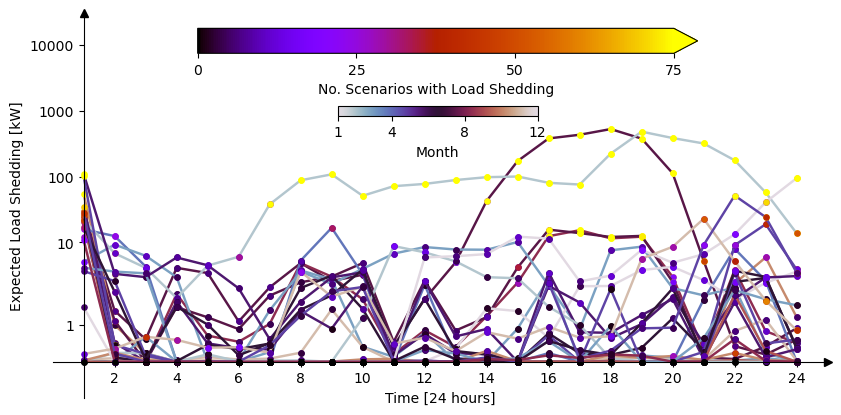

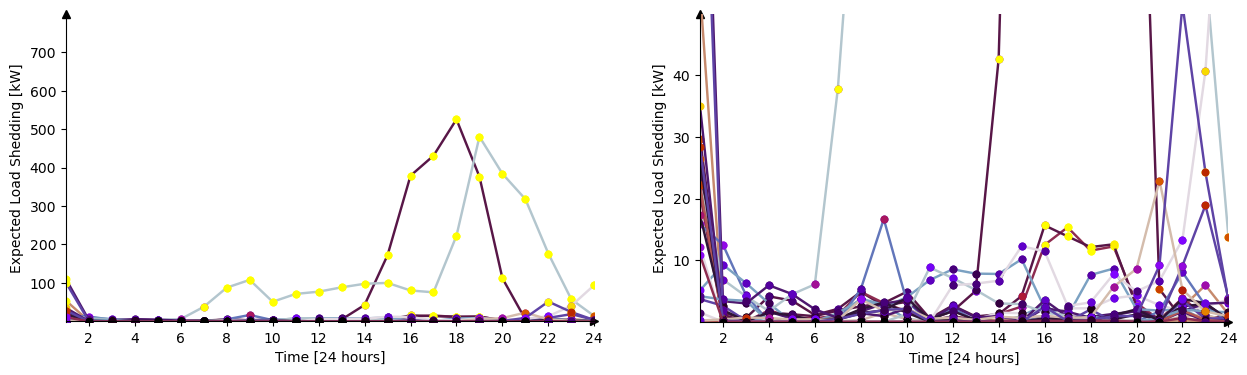

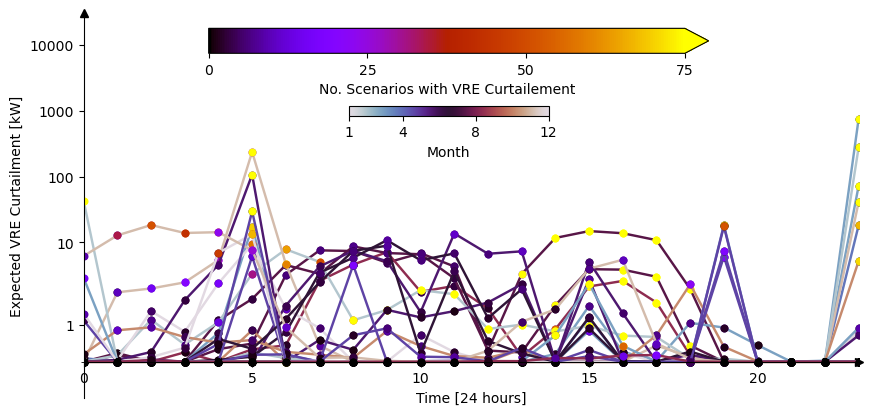

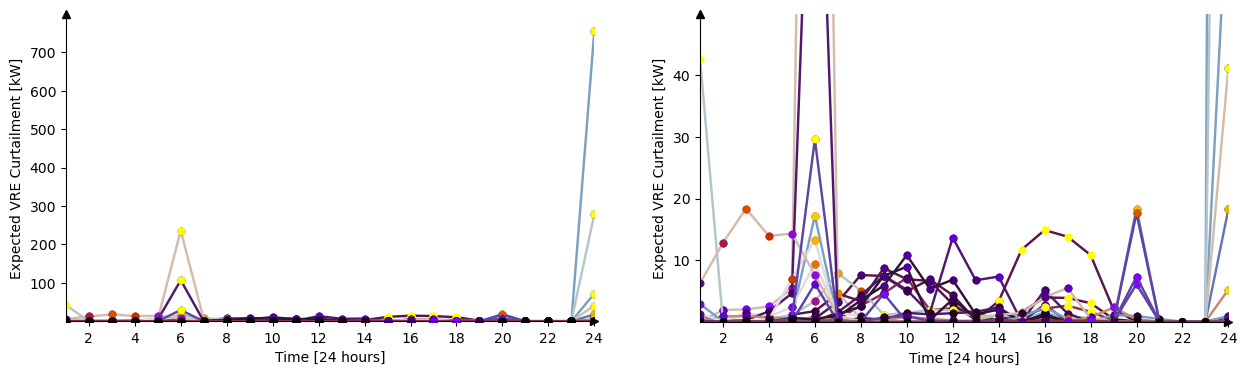

In [96]:
# Load Shedding Stats graph
def _plot_load_shed_stats(all_mean_load_shed_, all_prob_load_shed_, month_, vmin = .075):
    all_prob_load_shed_p_ = all_prob_load_shed_/vmin
    x_ = np.arange(0, all_prob_load_shed_.shape[0], 1)
    y_ = all_mean_load_shed_ + 1e-25
    print(x_.shape, y_.shape)

    #plt.style.use('default')
    
    fig = plt.figure(figsize = (10, 5))
    ax1 = fig.add_subplot(111) 
    
    cmap1 = mpl.colormaps['gnuplot']
    cmap2 = mpl.colormaps['twilight']
    
    # Move the left and bottom spines to x = 0 and y = 0, respectively.
    ax1.spines[["left", "bottom"]].set_position(("data", 0))
    # Hide the top and right spines.
    ax1.spines[["top", "right"]].set_visible(False)

    # Draw arrows (as black triangles: ">k"/"^k") at the end of the axes.  In each
    # case, one of the coordinates (0) is a data coordinate (i.e., y = 0 or x = 0,
    # respectively) and the other one (1) is an axes coordinate (i.e., at the very
    # right/top of the axes).  Also, disable clipping (clip_on=False) as the marker
    # actually spills out of the axes.
    ax1.plot(1, 0, ">k", transform = ax1.get_yaxis_transform(), 
                         clip_on   = False)
    ax1.plot(0, 1, "^k", transform = ax1.get_xaxis_transform(), 
                         clip_on   = False)

    for j in range(all_mean_load_shed_.shape[1]):

        list_ = [cmap1(all_prob_load_shed_p_[i, j]) for i in range(all_mean_load_shed_.shape[0])]
        ax1.set_prop_cycle('color', list_)

        ax1.plot(x_, y_[:, j], linewidth  = 1.75, 
                               color      = cmap2(month_[j]/12.),
                               marker     = '', 
                               markersize = 2.5, 
                               linestyle  = '-')
        
        for i in range(all_mean_vre_curtail_.shape[0]):
            ax1.plot(x_[i:i + 2], y_[i:i + 2, j], linewidth  = 1., 
                                                  marker     = '.', 
                                                  markersize = 7.5, 
                                                  linestyle  = '')

    cax = fig.add_axes([0.27, 0.8, 0.5, 0.05])
    mpl.colorbar.ColorbarBase(cax, cmap        = cmap1, 
                                   orientation = 'horizontal',
                                   norm        = mpl.colors.Normalize(0, vmin), 
                                   extend      = 'max',
                                   label       = 'No. Scenarios with Load Shedding',
                                   ticks       = [0., 25, 50, 75])
    
    cax = fig.add_axes([0.41, 0.675, 0.2, 0.02])
    mpl.colorbar.ColorbarBase(cax, cmap        = cmap2, 
                                   orientation = 'horizontal',
                                   norm        = mpl.colors.Normalize(1, 12), 
                                   label       = 'Month',
                                   ticks       = [1, 4, 8, 12])
    
    ax1.set_ylim(-1, 30000)
    ax1.set_xlim(-1, 24)
    #ax1.set_xlim(0, all_mean_vre_curtail_.shape[0] - 1)
    ax1.set_xticks(np.arange(0, all_mean_load_shed_.shape[0], 1)[1::2], np.arange(1, all_mean_load_shed_.shape[0] + 1, 1)[1::2])
    ax1.set_yscale('symlog') 
    ax1.set_yticks([1, 10, 100, 1000, 10000], [1, 10, 100, 1000, 10000])
    ax1.set_xlabel('Time [24 hours]')
    ax1.set_ylabel('Expected Load Shedding [kW]')
    
    plt.show() 
    
    fig = plt.figure(figsize = (15, 4))
    ax1 = fig.add_subplot(121) 
    
    cmap1 = mpl.colormaps['gnuplot']
    cmap2 = mpl.colormaps['twilight']

    # Move the left and bottom spines to x = 0 and y = 0, respectively.
    ax1.spines[["left", "bottom"]].set_position(("data", 0))
    # Hide the top and right spines.
    ax1.spines[["top", "right"]].set_visible(False)

    # Draw arrows (as black triangles: ">k"/"^k") at the end of the axes.  In each
    # case, one of the coordinates (0) is a data coordinate (i.e., y = 0 or x = 0,
    # respectively) and the other one (1) is an axes coordinate (i.e., at the very
    # right/top of the axes).  Also, disable clipping (clip_on=False) as the marker
    # actually spills out of the axes.
    ax1.plot(1, 0, ">k", transform = ax1.get_yaxis_transform(), 
                         clip_on   = False)
    ax1.plot(0, 1, "^k", transform = ax1.get_xaxis_transform(), 
                         clip_on   = False)

    for j in range(all_mean_load_shed_.shape[1]):

        list_ = [cmap1(all_prob_load_shed_p_[i, j]) for i in range(all_mean_load_shed_.shape[0])]
        ax1.set_prop_cycle('color', list_)

        ax1.plot(x_, y_[:, j], linewidth  = 1.75, 
                               color      = cmap2(month_[j]/12.),
                               marker     = '', 
                               markersize = 2.5, 
                               linestyle  = '-')
        
        for i in range(all_mean_vre_curtail_.shape[0]):
            ax1.plot(x_[i:i + 2], y_[i:i + 2, j], linewidth  = 1., 
                                                  marker     = '.', 
                                                  markersize = 9.5, 
                                                  linestyle  = '')

    
    ax1.set_ylim(-1, 800)
    ax1.set_xlim(-1, 24)
    ax1.set_xlim(0, all_mean_load_shed_.shape[0] - 1)
    ax1.set_xticks(np.arange(0, all_mean_load_shed_.shape[0], 1)[1::2], np.arange(1, all_mean_load_shed_.shape[0] + 1, 1)[1::2]) 
    ax1.set_yticks([100, 200, 300, 400, 500, 600, 700], [100, 200, 300, 400, 500, 600, 700])
    ax1.set_xlabel('Time [24 hours]')
    ax1.set_ylabel('Expected Load Shedding [kW]')
    
    ax2 = fig.add_subplot(122) 

    cmap1 = mpl.colormaps['gnuplot']
    cmap2 = mpl.colormaps['twilight']

    # Move the left and bottom spines to x = 0 and y = 0, respectively.
    ax2.spines[["left", "bottom"]].set_position(("data", 0))
    # Hide the top and right spines.
    ax2.spines[["top", "right"]].set_visible(False)

    # Draw arrows (as black triangles: ">k"/"^k") at the end of the axes.  In each
    # case, one of the coordinates (0) is a data coordinate (i.e., y = 0 or x = 0,
    # respectively) and the other one (1) is an axes coordinate (i.e., at the very
    # right/top of the axes).  Also, disable clipping (clip_on=False) as the marker
    # actually spills out of the axes.
    ax2.plot(1, 0, ">k", transform = ax2.get_yaxis_transform(), 
                         clip_on   = False)
    ax2.plot(0, 1, "^k", transform = ax2.get_xaxis_transform(), 
                         clip_on   = False)

    for j in range(all_mean_load_shed_.shape[1]):

        list_ = [cmap1(all_prob_load_shed_p_[i, j]) for i in range(all_mean_load_shed_.shape[0])]
        ax2.set_prop_cycle('color', list_)

        ax2.plot(x_, y_[:, j], linewidth  = 1.75, 
                               color      = cmap2(month_[j]/12.),
                               marker     = '', 
                               markersize = 2.5, 
                               linestyle  = '-')
        
        for i in range(all_mean_vre_curtail_.shape[0]):
            ax2.plot(x_[i:i + 2], y_[i:i + 2, j], linewidth  = 1., 
                                                  marker     = '.', 
                                                  markersize = 9.5, 
                                                  linestyle  = '')

    ax2.set_ylim(-0.01, 50)
    ax2.set_xlim(-1, 24)
    ax2.set_xlim(0, all_mean_load_shed_.shape[0] - 1)
    ax2.set_xticks(np.arange(0, all_mean_load_shed_.shape[0], 1)[1::2], np.arange(1, all_mean_load_shed_.shape[0] + 1, 1)[1::2])  
    ax2.set_yticks([10, 20, 30, 40], [10, 20, 30, 40])
    ax2.set_xlabel('Time [24 hours]')
    ax2.set_ylabel('Expected Load Shedding [kW]')
    
    plt.show() 
    
    
# VRE curtailment Stats graph
def _plot_vre_curtail_stats(all_mean_vre_curtail_, all_prob_vre_curtail_, month_, vmin = .075):
    
    all_prob_vre_curtail_p_ = all_prob_vre_curtail_/vmin
    x_ = np.arange(0, all_mean_vre_curtail_.shape[0], 1)
    y_ = all_mean_vre_curtail_ + 1e-25

    #plt.style.use('default')
    
    fig = plt.figure(figsize = (10, 5))
    ax1 = fig.add_subplot(111) 
    
    cmap1 = mpl.colormaps['gnuplot']
    cmap2 = mpl.colormaps['twilight']

    # Move the left and bottom spines to x = 0 and y = 0, respectively.
    ax1.spines[["left", "bottom"]].set_position(("data", 0))
    # Hide the top and right spines.
    ax1.spines[["top", "right"]].set_visible(False)

    # Draw arrows (as black triangles: ">k"/"^k") at the end of the axes.  In each
    # case, one of the coordinates (0) is a data coordinate (i.e., y = 0 or x = 0,
    # respectively) and the other one (1) is an axes coordinate (i.e., at the very
    # right/top of the axes).  Also, disable clipping (clip_on=False) as the marker
    # actually spills out of the axes.
    ax1.plot(1, 0, ">k", transform = ax1.get_yaxis_transform(), 
                         clip_on   = False)
    ax1.plot(0, 1, "^k", transform = ax1.get_xaxis_transform(), 
                         clip_on   = False)

    for j in range(all_mean_vre_curtail_.shape[1]):

        list_ = [cmap1(all_prob_vre_curtail_p_[i, j]) for i in range(all_mean_vre_curtail_.shape[0])]
        ax1.set_prop_cycle('color', list_)

        ax1.plot(x_, y_[:, j], linewidth  = 1.75, 
                               color      = cmap2(month_[j]/12.),
                               marker     = '', 
                               markersize = 2.5, 
                               linestyle  = '-')
        
        for i in range(all_mean_vre_curtail_.shape[0]):
            ax1.plot(x_[i:i + 2], y_[i:i + 2, j], linewidth  = 1., 
                                                  marker     = '.', 
                                                  markersize = 9.5, 
                                                  linestyle  = '')

    cax = fig.add_axes([0.25, 0.8, 0.5, 0.05])
    mpl.colorbar.ColorbarBase(cax, cmap        = cmap1, 
                                   orientation = 'horizontal',
                                   norm        = mpl.colors.Normalize(0, vmin), 
                                   extend      = 'max',
                                   label       = 'No. Scenarios with VRE Curtailement',
                                   ticks       = [0., 25, 50, 75])

    cax = fig.add_axes([0.39, 0.675, 0.2, 0.02])
    mpl.colorbar.ColorbarBase(cax, cmap        = cmap2, 
                                   orientation = 'horizontal',
                                   norm        = mpl.colors.Normalize(1, 12), 
                                   label       = 'Month',
                                   ticks       = [1, 4, 8, 12])
    
    ax1.set_ylim(-1, 30000)
    ax1.set_xlim(-1, 24)
    ax1.set_xlim(0, all_mean_vre_curtail_.shape[0] - 1)
    #ax1.set_xticks(np.arange(0, all_mean_vre_curtail_.shape[0], 1)[1::2], np.arange(1, all_mean_vre_curtail_.shape[0] + 1, 1)[1::2])
    ax1.set_yscale('symlog')
    ax1.set_yticks([1, 10, 100, 1000, 10000], [1, 10, 100, 1000, 10000])
    ax1.set_xlabel('Time [24 hours]')
    ax1.set_ylabel('Expected VRE Curtailment [kW]')
    plt.show()
    
    fig = plt.figure(figsize = (15, 4))
    ax1 = fig.add_subplot(121) 
    
    cmap1 = mpl.colormaps['gnuplot']
    cmap2 = mpl.colormaps['twilight']

    # Move the left and bottom spines to x = 0 and y = 0, respectively.
    ax1.spines[["left", "bottom"]].set_position(("data", 0))
    # Hide the top and right spines.
    ax1.spines[["top", "right"]].set_visible(False)

    # Draw arrows (as black triangles: ">k"/"^k") at the end of the axes.  In each
    # case, one of the coordinates (0) is a data coordinate (i.e., y = 0 or x = 0,
    # respectively) and the other one (1) is an axes coordinate (i.e., at the very
    # right/top of the axes).  Also, disable clipping (clip_on=False) as the marker
    # actually spills out of the axes.
    ax1.plot(1, 0, ">k", transform = ax1.get_yaxis_transform(), 
                         clip_on   = False)
    ax1.plot(0, 1, "^k", transform = ax1.get_xaxis_transform(), 
                         clip_on   = False)

    for j in range(all_mean_vre_curtail_.shape[1]):

        list_ = [cmap1(all_prob_vre_curtail_p_[i, j]) for i in range(all_mean_vre_curtail_.shape[0])]
        ax1.set_prop_cycle('color', list_)

        ax1.plot(x_, y_[:, j], linewidth  = 1.75, 
                               color      = cmap2(month_[j]/12.),
                               marker     = '', 
                               markersize = 2.5, 
                               linestyle  = '-')
        
        for i in range(all_mean_vre_curtail_.shape[0]):
            ax1.plot(x_[i:i + 2], y_[i:i + 2, j], linewidth  = 1., 
                                                  marker     = '.', 
                                                  markersize = 9.5, 
                                                  linestyle  = '')

    
    ax1.set_ylim(-1, 800)
    ax1.set_xlim(-1, 24)

    ax1.set_xlim(0, all_mean_vre_curtail_.shape[0] - 1)
    ax1.set_xticks(np.arange(0, all_mean_vre_curtail_.shape[0], 1)[1::2], np.arange(1, all_mean_vre_curtail_.shape[0] + 1, 1)[1::2])
    

    #ax1.set_yscale('symlog')
    
    ax1.set_yticks([100, 200, 300, 400, 500, 600, 700], [100, 200, 300, 400, 500, 600, 700])

    ax1.set_xlabel('Time [24 hours]')
    ax1.set_ylabel('Expected VRE Curtailment [kW]')
    
    ax2 = fig.add_subplot(122) 

    cmap1 = mpl.colormaps['gnuplot']
    cmap2 = mpl.colormaps['twilight']

    # Move the left and bottom spines to x = 0 and y = 0, respectively.
    ax2.spines[["left", "bottom"]].set_position(("data", 0))
    # Hide the top and right spines.
    ax2.spines[["top", "right"]].set_visible(False)

    # Draw arrows (as black triangles: ">k"/"^k") at the end of the axes.  In each
    # case, one of the coordinates (0) is a data coordinate (i.e., y = 0 or x = 0,
    # respectively) and the other one (1) is an axes coordinate (i.e., at the very
    # right/top of the axes).  Also, disable clipping (clip_on=False) as the marker
    # actually spills out of the axes.
    ax2.plot(1, 0, ">k", transform = ax2.get_yaxis_transform(), 
                         clip_on   = False)
    ax2.plot(0, 1, "^k", transform = ax2.get_xaxis_transform(), 
                         clip_on   = False)

    for j in range(all_mean_vre_curtail_.shape[1]):

        list_ = [cmap1(all_prob_vre_curtail_p_[i, j]) for i in range(all_mean_vre_curtail_.shape[0])]
        ax2.set_prop_cycle('color', list_)

        ax2.plot(x_, y_[:, j], linewidth  = 1.75, 
                               color      = cmap2(month_[j]/12.),
                               marker     = '', 
                               markersize = 2.5, 
                               linestyle  = '-')
        
        for i in range(all_mean_vre_curtail_.shape[0]):
            ax2.plot(x_[i:i + 2], y_[i:i + 2, j], linewidth  = 1., 
                                                  marker     = '.', 
                                                  markersize = 9.5, 
                                                  linestyle  = '')

    ax2.set_ylim(-0.01, 50)
    ax2.set_xlim(-1, 24)
    ax2.set_xlim(0, all_mean_vre_curtail_.shape[0] - 1)
    ax2.set_xticks(np.arange(0, all_mean_vre_curtail_.shape[0], 1)[1::2], np.arange(1, all_mean_vre_curtail_.shape[0] + 1, 1)[1::2])    
    ax2.set_yticks([10, 20, 30, 40], [10, 20, 30, 40])
    ax2.set_xlabel('Time [24 hours]')
    ax2.set_ylabel('Expected VRE Curtailment [kW]')
    
    plt.show() 
    
    
_plot_load_shed_stats(all_mean_load_shed_, all_prob_load_shed_, month_, vmin = 75)
_plot_vre_curtail_stats(all_mean_vre_curtail_, all_prob_vre_curtail_, month_, vmin = 75)